## Predictive Analytics for Risk Profiling of COVID-19 Patients

In [57]:
# load important stuff
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# These are some new scikit learn toys that will make your life easier (see below)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline

### Read data

In [58]:
import os 
os.chdir ('/Users/tangziyu/Desktop/AI Opening')

In [59]:
covid = pd.read_csv('Covid19_SourceFile.csv')
sample = pd.read_csv('1000AnalyticFileSample.csv')
dx = pd.read_csv('ICD10_Dx_TaxonomyTree.csv')
age = pd.read_csv('age.csv')

In [60]:
age.head()

,AgeCode,AgeGroup,Map to
0,1,Under 1,RefUnder18
1,2,1月17日,RefUnder18
2,3,18-24,Age_18_39
3,4,25-29,Age_18_39
4,5,30-34,Age_18_39


In [61]:
sample.head()

,Patient ID,Mortality (1= death),Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,...,UROLG_GEN_Kidney,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status_A,UROLG_GEN_Status_B,UROLG_GEN_Status2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
dx.head()

,ICD10 Dx Code,ICD10 Dx Code Desc,DGL_1_Desc,DGL_2_Desc,DGL_3_Extend
0,F4320,"Adjustment disorder, unspecified",behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
1,F4322,Adjustment disorder with anxiety,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
2,F4323,Adjustment disorder with mixed anxiety and dep...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
3,F4324,Adjustment disorder with disturbance of conduct,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
4,F4325,Adjustment disorder w mixed disturb of emotion...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress


In [63]:
covid.head()

,Patient ID,AgeCode,SexCode,DX1,DX2,DX3,DX4,DX5,DX6,DX7,...,DX12,DX13,DX14,DX15,DX16,DX17,DX18,DX19,DX20,Mortality (1= death)
0,1,13,2.0,L600,J45909,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,11,2.0,Z86010,K5730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,12,2.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,10,1.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,13,2.0,Z1211,I4901,Z95810,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Data Preparation

#### convert gender to be 0-1 dummy

In [64]:
covid = covid.replace({'SexCode': 2.0}, 0)
covid['SexCode'] = covid['SexCode'].fillna(0)
convert_dict = {'SexCode': int
               } 
covid = covid.astype(convert_dict) 
covid = covid.rename(columns={'SexCode': 'Gender_Male'})

#### map age

In [65]:
covid_age = pd.merge(covid,
                 age[['AgeCode', 'Map to ']],
                 on='AgeCode')
map_age = pd.get_dummies(covid_age['Map to '])
map_age = map_age[map_age.columns[0:6]] 
covid_age = pd.concat([covid_age, map_age], axis=1)
covid_age = covid_age.drop(['AgeCode', 'Map to '],axis=1) 
covid = covid_age
covid = covid.sort_values(by=['Patient ID'])

##### check column with all nulls

In [66]:
print(covid.isnull().all())

Patient ID              False
Gender_Male             False
DX1                     False
DX2                     False
DX3                     False
DX4                     False
DX5                     False
DX6                     False
DX7                     False
DX8                     False
DX9                     False
DX10                    False
DX11                    False
DX12                    False
DX13                    False
DX14                    False
DX15                    False
DX16                    False
DX17                    False
DX18                    False
DX19                    False
DX20                    False
Mortality (1= death)    False
Age_18_39               False
Age_40_49               False
Age_50_59               False
Age_60_69               False
Age_70_74               False
Age_75_99               False
dtype: bool


#### convert code of dx to class name

In [67]:
names = ['DX1',
 'DX2',
 'DX3',
 'DX4',
 'DX5',
 'DX6',
 'DX7',
 'DX8',
 'DX9',
 'DX10',
 'DX11',
 'DX12',
 'DX13',
 'DX14',
 'DX15',
 'DX16',
 'DX17',
 'DX18',
 'DX19',
 'DX20',]
for name in names:
    covid[name] = covid[name] .map(dx.set_index('ICD10 Dx Code')['DGL_3_Extend'])

##### map dxs to be dummies according to requirements

In [68]:
covid_dx = covid
covid_dx = covid_dx.melt('Patient ID').groupby(['Patient ID', 'value']).size().unstack(fill_value=0)

In [69]:
covid_dx = covid_dx.reset_index()
covid_final = pd.merge(
                 covid[['Patient ID','Mortality (1= death)','Age_18_39','Age_40_49','Age_50_59',
                        'Age_60_69','Age_70_74','Age_75_99','Gender_Male']],covid_dx,
                 on='Patient ID')

In [70]:
covid_final.columns.tolist()

['Patient ID',
 'Mortality (1= death)',
 'Age_18_39',
 'Age_40_49',
 'Age_50_59',
 'Age_60_69',
 'Age_70_74',
 'Age_75_99',
 'Gender_Male',
 0,
 1,
 'BEHAV_AdjustmentStress',
 'BEHAV_Affective_A',
 'BEHAV_Affective_B',
 'BEHAV_Anxiety_Phobia',
 'BEHAV_Ocd_Adhd',
 'BEHAV_Other_Nos_A',
 'BEHAV_Other_Nos_B',
 'BEHAV_Personality_Conduct',
 'BEHAV_Psychosis',
 'BEHAV_Substance_Abuse',
 'CHEST_Airway_Lungs_A',
 'CHEST_Airway_Lungs_B',
 'CHEST_Chest_Wall_A',
 'CHEST_Chest_Wall_B',
 'CHEST_Complication',
 'CHEST_Lung',
 'CHEST_Metastatic',
 'CHEST_Other_Nec',
 'CHEST_Other_Nos_A',
 'CHEST_Other_Nos_B',
 'CHEST_Pers_Fam_Hx_Ds',
 'CHEST_Pleural',
 'CHEST_Pneumonia',
 'CHEST_Screening',
 'CHEST_Status_A',
 'CHEST_Status_B',
 'CHEST_Uri_A',
 'CHEST_Uri_B',
 'CVASC_Arterial_A',
 'CVASC_Arterial_B',
 'CVASC_Cardiac_A',
 'CVASC_Cardiac_B',
 'CVASC_Complication_A',
 'CVASC_Complication_B',
 'CVASC_Heart_Rhythm_A',
 'CVASC_Heart_Rhythm_B',
 'CVASC_Other',
 'CVASC_Other_Nos_A',
 'CVASC_Other_Nos_B',
 'C

##### convert 0-1 dummies

In [71]:
covid_final = covid_final.drop([0,1],axis=1) 
names = covid_final.columns.tolist()[9:]
for column in names:
    covid_final.loc[covid_final[column]!=0, column] = 1

In [72]:
covid_final

,Patient ID,Mortality (1= death),Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,...,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status2,UROLG_GEN_Status_A,UROLG_GEN_Status_B,Undefined_Undefined
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# check the dummy variable - only 0 and 1
for column in names:
    print(covid_final[column].max()) 

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


#### check the results with sample data

In [76]:
covid_final.iloc[0]

Patient ID                   1
Mortality (1= death)         0
Age_18_39                    0
Age_40_49                    0
Age_50_59                    0
Age_60_69                    0
Age_70_74                    1
Age_75_99                    0
Gender_Male                  0
BEHAV_AdjustmentStress       0
BEHAV_Affective_A            0
BEHAV_Affective_B            0
BEHAV_Anxiety_Phobia         0
BEHAV_Ocd_Adhd               0
BEHAV_Other_Nos_A            0
BEHAV_Other_Nos_B            0
BEHAV_Personality_Conduct    0
BEHAV_Psychosis              0
BEHAV_Substance_Abuse        0
CHEST_Airway_Lungs_A         1
CHEST_Airway_Lungs_B         0
CHEST_Chest_Wall_A           0
CHEST_Chest_Wall_B           0
CHEST_Complication           0
CHEST_Lung                   0
CHEST_Metastatic             0
CHEST_Other_Nec              0
CHEST_Other_Nos_A            0
CHEST_Other_Nos_B            0
CHEST_Pers_Fam_Hx_Ds         0
                            ..
NEURO_Other                  0
NEURO_Ot

In [77]:
sample.columns.difference(covid_final.columns)

Index(['CVASC_Screening_A', 'DERMA_Complication', 'DERMA_Screening',
       'DERMA_Whole_Body_Nos_A', 'ENTD__Malignant_B', 'EYE___Head',
       'MSKLT_Screening', 'NEURO_Complication_B', 'NEURO_Screening'],
      dtype='object')

In [78]:
len(dx['DGL_3_Extend'].unique())

227

Besides, some of the dx don't exist in the cases - that's why we just have 220 dx instead of 229.

### Export data

In [79]:
covid_final.to_csv('final result.csv')

### Modeling

#### Text analysis

##### Most frequently appearing diseases of death

In [21]:
death = covid[covid['Mortality (1= death)']==1]
text = death.iloc[:,0:21]
text = text.drop(['Gender_Male'],axis=1) 
text = text.melt(id_vars = 'Patient ID')
text = text.iloc[:,2]
text = text.dropna()
words = text.to_json()
#text.to_csv('text analysis result.csv')

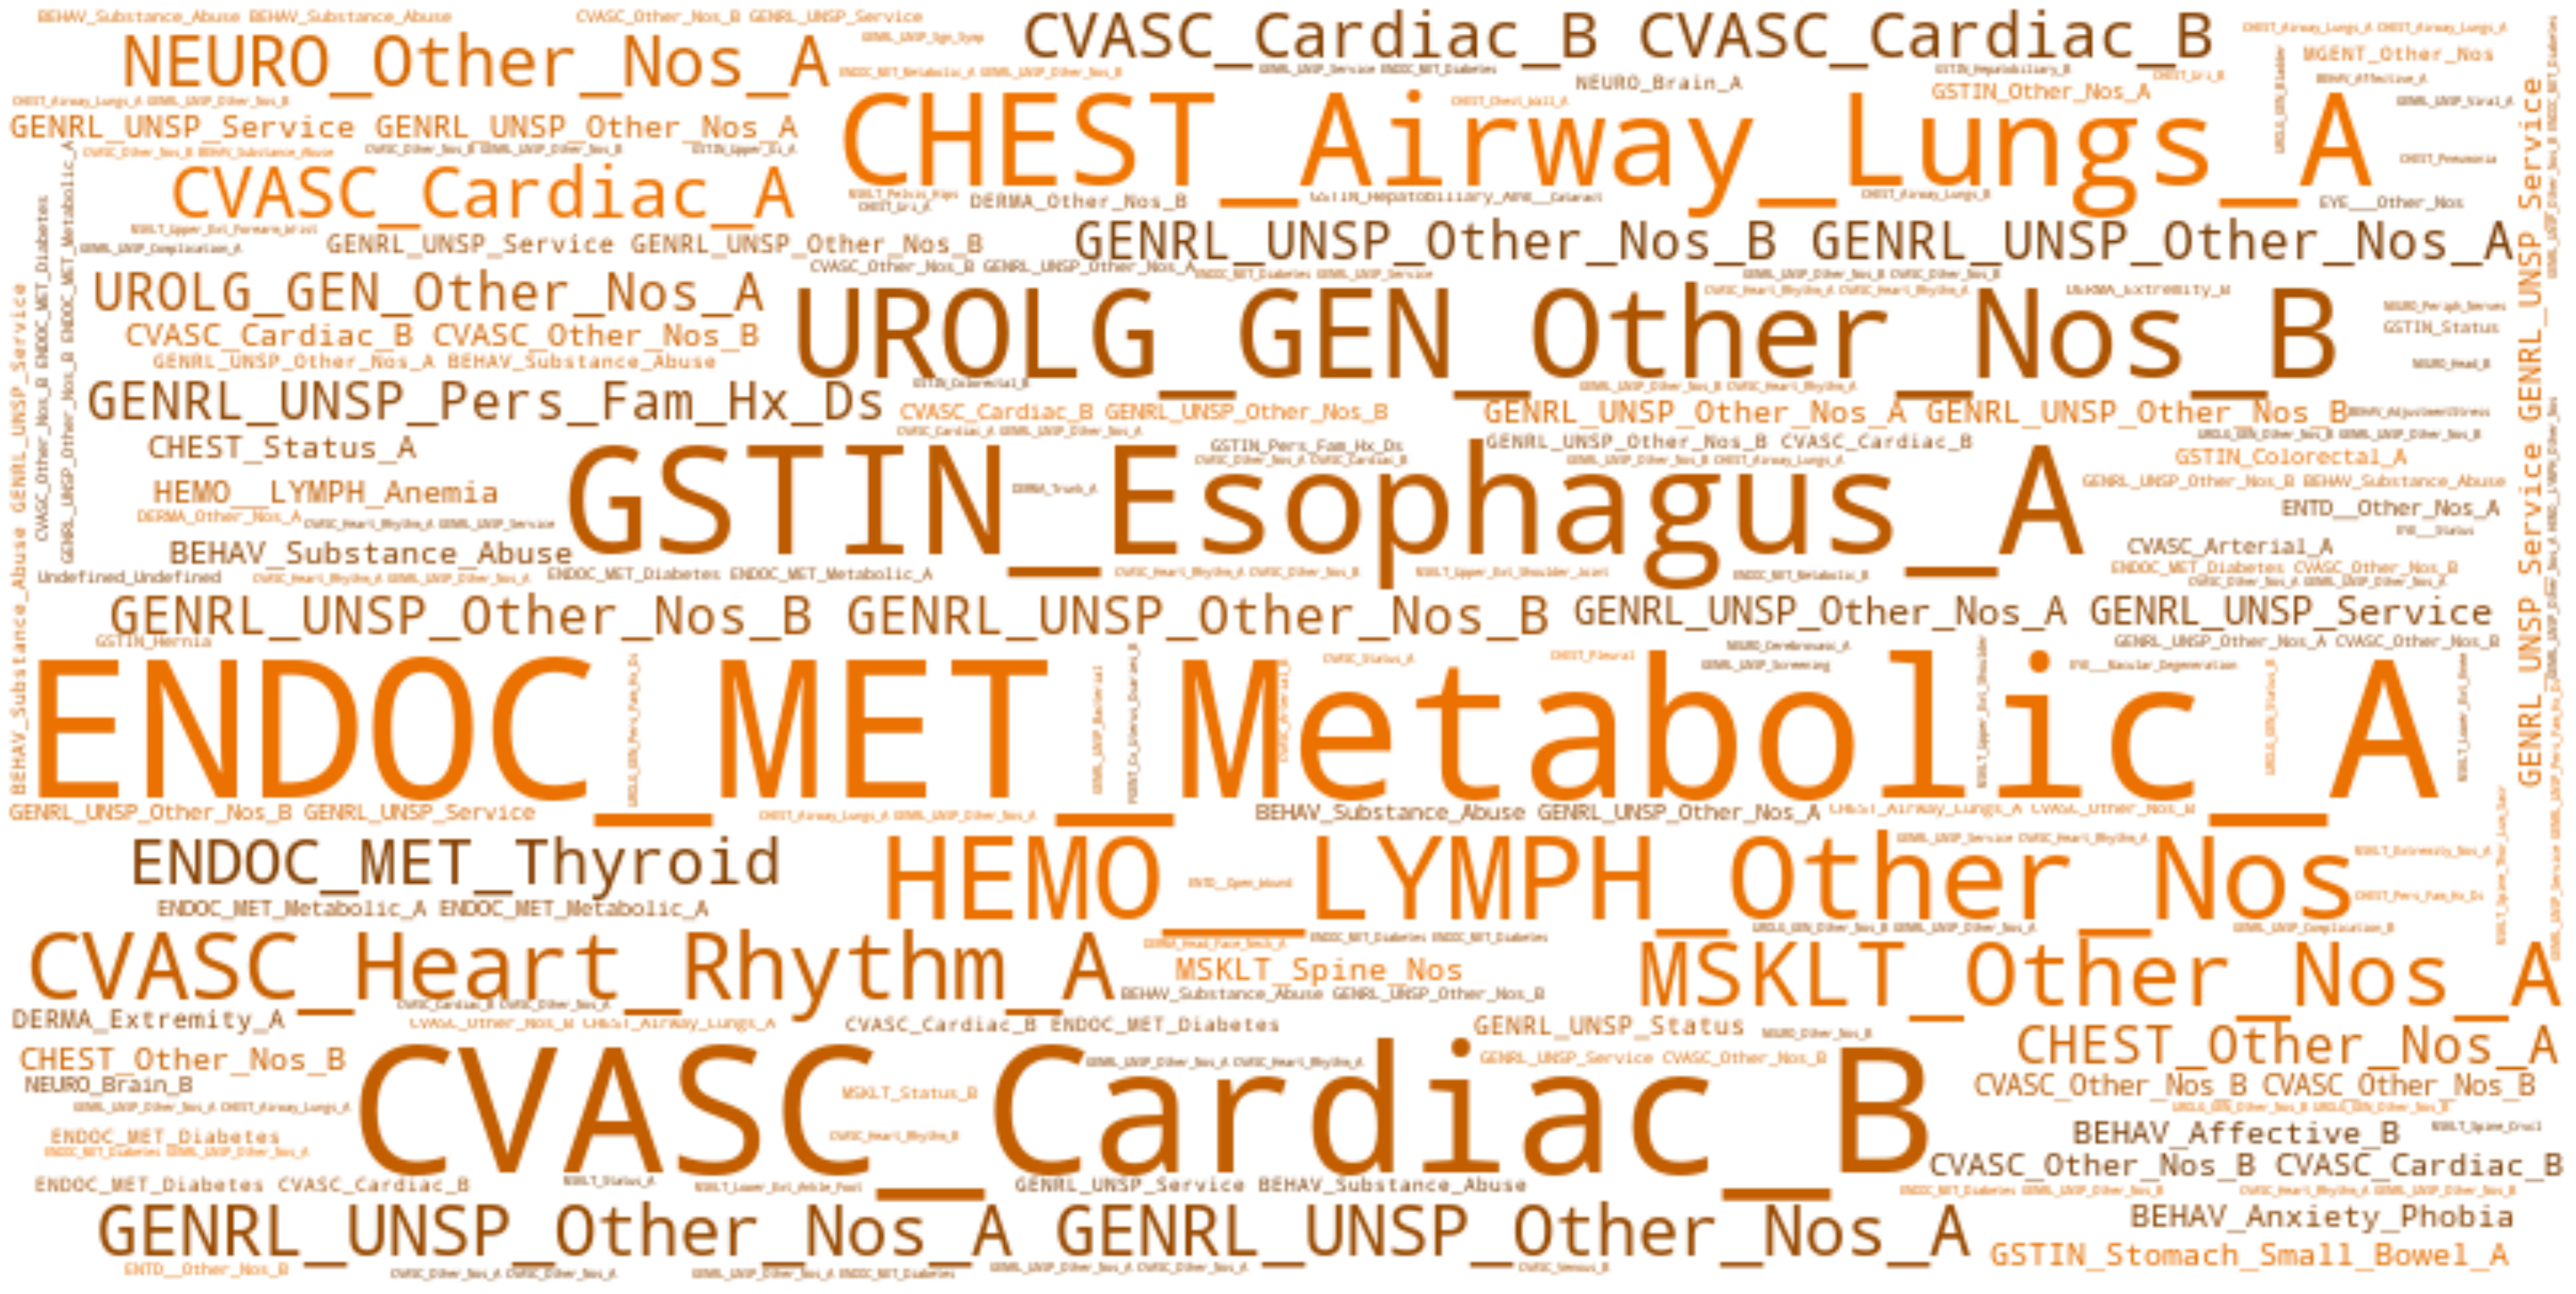

In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def generate_wordcloud(word):
    word_cloud = WordCloud(width=800, height=400,background_color='white',max_font_size=60, stopwords=STOPWORDS,color_func=random_color_func).generate(words)
    plt.figure(figsize=(40,40),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_wordcloud(words)

#### Balancing classes

(array([349363.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  21270.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

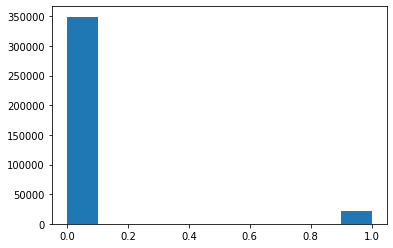

In [80]:
# this plot shows how unbalanced the data set is
plt.hist(covid_final.iloc[:,1])

In [81]:
# generate special classes for types
count0, count1 = covid_final.iloc[:,1].value_counts()
health = covid_final[covid_final.iloc[:,1]==0]
death = covid_final[covid_final.iloc[:,1]==1]

##### Undersample Class 0

In [82]:
# under sampling
# Generate sample of class 0 types matching number of class 1 types
under0 = health.sample(count1)
model_dta = pd.concat([under0,death],axis=0)
model_dta

,Patient ID,Mortality (1= death),Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,...,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status2,UROLG_GEN_Status_A,UROLG_GEN_Status_B,Undefined_Undefined
327896,327897,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
158218,158219,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
276367,276368,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
280686,280687,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
190428,190429,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
51247,51248,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304195,304196,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
139700,139701,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
336489,336490,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117813,117814,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([21270.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21270.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

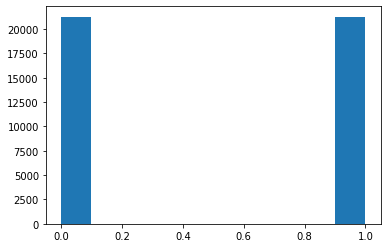

In [83]:
plt.hist(model_dta.iloc[:,1])

#### Setting data set

In [84]:
# set up data, and check if balanced
y = model_dta.iloc[:,1]
X = model_dta.iloc[:,2:]
print(np.mean(y))
X.head()

0.5


,Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,BEHAV_Affective_A,BEHAV_Affective_B,...,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status2,UROLG_GEN_Status_A,UROLG_GEN_Status_B,Undefined_Undefined
327896,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158218,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276367,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280686,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190428,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Logistic regression with penalty

In [36]:
from sklearn.model_selection import GridSearchCV
nmc = 100
# Build pipeline
#   Note: model names are given names, but all small letters (odd system)
fullModel = make_pipeline(StandardScaler(),LogisticRegression(solver = "lbfgs"))

# List of C's to try
Clist = np.power(10.,range(-5,10))

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __
param_grid={'logisticregression__C':Clist}

# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)

# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)

# implement search
grid_search.fit(X,y)

# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_logisticregression__C']])

    rank_test_score  mean_test_score param_logisticregression__C
0                15         0.922954                       1e-05
1                14         0.930917                      0.0001
2                13         0.938601                       0.001
3                 2         0.940503                        0.01
4                 1         0.940544                         0.1
5                 3         0.940486                           1
6                 4         0.940480                          10
7                 4         0.940480                         100
8                 4         0.940480                        1000
9                 7         0.940476                       10000
10                7         0.940476                      100000
11                7         0.940476                       1e+06
12                7         0.940476                       1e+07
13                7         0.940476                       1e+08
14                7      

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
scaler = StandardScaler().fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2  = scaler.transform(X_test)

logisticMod = LogisticRegression(C=0.1,solver='lbfgs')
logisticMod.fit(X_train2, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
from sklearn.metrics import confusion_matrix

yhat = logisticMod.predict(X_test2)
cmat = confusion_matrix(y_test,yhat)
print(cmat)
tn, fp, fn, tp = cmat.ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
print(accuracy)
from sklearn.metrics import f1_score
f1_score(y_test, yhat)

[[5003  301]
 [ 306 5025]]
0.9429243065350259


0.9430421319320635

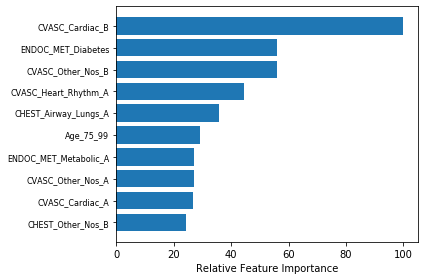

In [77]:
clf = logisticMod.fit(X_train2, y_train)
#print(clf.coef_, clf.intercept_)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5

dta= feature_importance[sorted_idx][217:227]

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, dta, align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx][217:227], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Random Forest

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
nmc = 100
#  Note:  no need for scaling, back to simple parameters
# set up dictionary for grid search
param_grid={'max_features':np.arange(1,11,1),'max_depth':np.arange(2,12,2),'n_estimators':[100]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_features','param_max_depth']])

#0.920348      

NameError: name 'GridSearchCV' is not defined

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
scaler = StandardScaler().fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2  = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,max_features=5,max_depth=10,random_state=1124)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.919
Accuracy on test set: 0.926


In [95]:
from sklearn.metrics import confusion_matrix

yhat = forest.predict(X_test)
cmat = confusion_matrix(y_test,yhat)
print(cmat)
tn, fp, fn, tp = cmat.ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
print(accuracy)
from sklearn.metrics import f1_score
f1_score(y_test, yhat)

[[4900  404]
 [ 387 4944]]
0.9256229431123648


0.9259293941380279

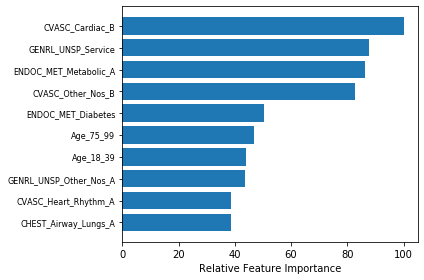

In [46]:
result = forest.fit(X_train, y_train)

feature_importance = result.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5

dta= feature_importance[sorted_idx][217:227]

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, dta, align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx][217:227], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Boosted Tree

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
nmc = 100
# set up dictionary for grid search
param_grid={'n_estimators':[10,25,50,75],'max_depth':[2,3,4],'learning_rate':[0.1,0.2,0.5]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame 
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_n_estimators','param_max_depth','param_learning_rate']])

    rank_test_score  mean_test_score param_n_estimators param_max_depth  \
0                36         0.860854                 10               2   
1                32         0.898375                 25               2   
2                25         0.914399                 50               2   
3                21         0.920747                 75               2   
4                35         0.881047                 10               3   
5                30         0.907253                 25               3   
6                22         0.919528                 50               3   
7                16         0.925366                 75               3   
8                33         0.890189                 10               4   
9                28         0.912960                 25               4   
10               18         0.923404                 50               4   
11               13         0.929151                 75               4   
12               34      

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
nmc = 100
# set up dictionary for grid search
param_grid={'n_estimators':[100],'max_depth':[4,5],'learning_rate':[0.5]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_n_estimators','param_max_depth','param_learning_rate']])

   rank_test_score  mean_test_score param_n_estimators param_max_depth  \
0                1         0.937079                100               4   
1                2         0.935929                100               5   

  param_learning_rate  
0                 0.5  
1                 0.5  


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
nmc = 100
# set up dictionary for grid search
param_grid={'n_estimators':[75],'max_depth':[4,5],'learning_rate':[0.5]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)

In [29]:
print(results[['rank_test_score','mean_test_score','param_n_estimators','param_max_depth','param_learning_rate']])

   rank_test_score  mean_test_score param_n_estimators param_max_depth  \
0                1         0.936939                 75               4   
1                2         0.936270                 75               5   

  param_learning_rate  
0                 0.5  
1                 0.5  


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=75,max_depth=4,learning_rate=0.5,random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.940


In [92]:
result

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=75,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

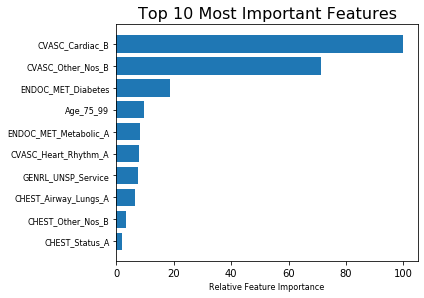

In [108]:
result = gbrt.fit(X_test, y_test)

feature_importance = result.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5

dta= feature_importance[sorted_idx][217:227]

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, dta, align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx][217:227], fontsize=8)
featax.set_xlabel('Relative Feature Importance',fontsize = 8)


plt.tight_layout()
plt.title('Top 10 Most Important Features',fontsize = 16)
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix

yhat = gbrt.predict(X_test)
cmat = confusion_matrix(y_test,yhat)
print(cmat)
tn, fp, fn, tp = cmat.ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
print(accuracy)


[[5116  188]
 [ 252 5079]]
0.9586271744240714


In [105]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5304
           1       0.96      0.95      0.96      5331

    accuracy                           0.96     10635
   macro avg       0.96      0.96      0.96     10635
weighted avg       0.96      0.96      0.96     10635



In [61]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat,pos_label=1)
metrics.auc(fpr, tpr)

0.940104239609354

In [116]:
np.array(X.columns)[sorted_idx][217:227]

array(['CHEST_Status_A', 'CHEST_Other_Nos_B', 'CHEST_Airway_Lungs_A',
       'GENRL_UNSP_Service', 'CVASC_Heart_Rhythm_A',
       'ENDOC_MET_Metabolic_A', 'Age_75_99', 'ENDOC_MET_Diabetes',
       'CVASC_Other_Nos_B', 'CVASC_Cardiac_B'], dtype=object)

In [22]:
y = covid_final.iloc[:,1]
X = covid_final.iloc[:,2:]
print(np.mean(y))
X.head()

0.05738830595224926


,Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male
0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0


In [44]:
# set up data, and check if balanced
y_balance = model_dta.iloc[:,1]
X_balance = model_dta.iloc[:,2:]
X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(X_balance,y_balance,test_size=0.25,random_state=0)

In [45]:

y_original = covid_final.iloc[:,1]
X_original = covid_final.iloc[:,2:]
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original,y_original,test_size=0.25,random_state=0)


In [113]:
import os 
os.chdir ('/Users/tangziyu/Desktop/AI Opening')
df = pd.read_csv('final result.csv')
df = df[df.columns[2:-1].to_list()]
X = df[df.columns[1:]].values
y = df['Mortality (1= death)'].values

In [115]:
y = covid_final.iloc[:,1]
X = covid_final.iloc[:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_test

,Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,BEHAV_Affective_A,BEHAV_Affective_B,...,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status2,UROLG_GEN_Status_A,UROLG_GEN_Status_B,Undefined_Undefined
349125,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
352975,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214334,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288174,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212857,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139298,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
291728,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223092,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182363,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
